In [ ]:
print(" Installing NLP libraries...")
!pip install -q textblob
!pip install -q wordcloud
!pip install -q plotly
print(" All libraries installed!\n")


 Installing NLP libraries...
 All libraries installed!



In [ ]:
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings('ignore')
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob
# Download NLTK data
print(" Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
print(" NLTK data downloaded")
# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, auc)
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
print(" All libraries imported successfully!")



 NLTK data downloaded
 All libraries imported successfully!


In [ ]:
print("="*60)
print("GENERATING SENTIMENT DATASET")
print("="*60)
np.random.seed(42)
positive_templates = [
    "This product is {adj1}! {adj2} quality and great value.",
    "{adj1} purchase! Highly recommend. Very {adj2}.",
    "Absolutely {adj1}! Best product I've bought. So {adj2}.",
    "Outstanding! The quality is {adj1} and {adj2}.",
    "{adj2} experience! The product is {adj1} and works perfectly.",
    "Love it! {adj1} quality and {adj2} service.",
    "Fantastic product! {adj1} and {adj2}. Worth every penny.",
    "Impressive! Very {adj1} and {adj2} design.",
    "Excellent! Exceeded expectations. {adj1} and {adj2}.",
    "Perfect! Exactly what I needed. {adj1} and {adj2}."
]

positive_adj = ['excellent', 'amazing', 'wonderful', 'great', 'fantastic',
                'outstanding', 'superb', 'brilliant', 'perfect', 'awesome']
negative_templates = [
    "This product is {adj1}. Very {adj2} quality.",
    "{adj1} purchase. Completely {adj2}. Not recommended.",
    "Absolutely {adj1}! Worst product ever. So {adj2}.",
    "Terrible! The quality is {adj1} and {adj2}.",
    "{adj2} experience! The product is {adj1} and doesn't work.",
    "Hate it! {adj1} quality and {adj2} service.",
    "Horrible product! {adj1} and {adj2}. Waste of money.",
    "Disappointing! Very {adj1} and {adj2} design.",
    "Poor quality! Below expectations. {adj1} and {adj2}.",
    "Awful! Not what I expected. {adj1} and {adj2}."
]

negative_adj = ['terrible', 'awful', 'horrible', 'bad', 'poor',
                'disappointing', 'unsatisfactory', 'defective', 'useless', 'worthless']
neutral_templates = [
    "This product is okay. It's {adj1} but nothing special.",
    "{adj1} product. Does the job. Nothing more.",
    "Average quality. {adj1} but not {adj2}.",
    "It's fine. {adj1} for the price.",
    "Acceptable product. {adj1} but could be better.",
]

neutral_adj = ['okay', 'average', 'decent', 'acceptable', 'fair', 'moderate', 'standard']
n_reviews = 3000

reviews = []
labels = []

for _ in range(int(n_reviews * 0.4)):
    template = np.random.choice(positive_templates)
    adj1 = np.random.choice(positive_adj)
    adj2 = np.random.choice(positive_adj)
    review = template.format(adj1=adj1, adj2=adj2)
    reviews.append(review)
    labels.append(1)
for _ in range(int(n_reviews * 0.4)):
    template = np.random.choice(negative_templates)
    adj1 = np.random.choice(negative_adj)
    adj2 = np.random.choice(negative_adj)
    review = template.format(adj1=adj1, adj2=adj2)
    reviews.append(review)
    labels.append(0)

for _ in range(int(n_reviews * 0.2)):
    template = np.random.choice(neutral_templates)
    adj1 = np.random.choice(neutral_adj)
    adj2 = np.random.choice(positive_adj + negative_adj)
    review = template.format(adj1=adj1, adj2=adj2)
    reviews.append(review)
    # Randomly assign neutral to positive or negative
    labels.append(np.random.choice([0, 1]))

# Create DataFrame
df = pd.DataFrame({
    'review': reviews,
    'sentiment': labels
})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f" Dataset generated!")
print(f"Total reviews: {len(df):,}")
print(f"\n Sentiment distribution:")
print(df['sentiment'].value_counts())
print(f"\nPositive: {(df['sentiment']==1).sum():,} ({(df['sentiment']==1).sum()/len(df)*100:.1f}%)")
print(f"Negative: {(df['sentiment']==0).sum():,} ({(df['sentiment']==0).sum()/len(df)*100:.1f}%)")
print("\n Sample reviews:")
print(df.head(10))



GENERATING SENTIMENT DATASET
 Dataset generated!
Total reviews: 3,000

 Sentiment distribution:
sentiment
1    1514
0    1486
Name: count, dtype: int64

Positive: 1,514 (50.5%)
Negative: 1,486 (49.5%)

 Sample reviews:
                                              review  sentiment
0  Horrible product! terrible and poor. Waste of ...          0
1  Excellent! Exceeded expectations. wonderful an...          1
2  Absolutely horrible! Worst product ever. So wo...          0
3  Love it! fantastic quality and outstanding ser...          1
4                     It's fine. okay for the price.          0
5  Absolutely perfect! Best product I've bought. ...          1
6  worthless purchase. Completely terrible. Not r...          0
7  Hate it! disappointing quality and disappointi...          0
8  wonderful experience! The product is great and...          1
9    acceptable product. Does the job. Nothing more.          1


In [ ]:
print("\n" + "="*60)
print("TEXT PREPROCESSING")
print("="*60)

class TextPreprocessor:
    """Complete text preprocessing pipeline"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()

    def clean_text(self, text):
        """Basic cleaning"""
        # Lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove email
        text = re.sub(r'\S+@\S+', '', text)

        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def remove_stopwords(self, text):
        """Remove stopwords"""
        words = text.split()
        filtered = [w for w in words if w not in self.stop_words]
        return ' '.join(filtered)

    def lemmatize(self, text):
        """Lemmatize text"""
        words = text.split()
        lemmatized = [self.lemmatizer.lemmatize(w) for w in words]
        return ' '.join(lemmatized)

    def stem(self, text):
        """Stem text"""
        words = text.split()
        stemmed = [self.stemmer.stem(w) for w in words]
        return ' '.join(stemmed)

    def preprocess(self, text, remove_stopwords=True, lemmatize=True):
        """Full preprocessing pipeline"""
        text = self.clean_text(text)
        if remove_stopwords:
            text = self.remove_stopwords(text)
        if lemmatize:
            text = self.lemmatize(text)
        return text

# Initialize preprocessor
preprocessor = TextPreprocessor()

print(" Preprocessing all reviews...")
df['cleaned_review'] = df['review'].apply(preprocessor.preprocess)

print(" Preprocessing completed!")
print("\n Before and After:")
for i in range(3):
    print(f"\nOriginal: {df['review'].iloc[i]}")
    print(f"Cleaned:  {df['cleaned_review'].iloc[i]}")



TEXT PREPROCESSING
 Preprocessing all reviews...
 Preprocessing completed!

 Before and After:

Original: Horrible product! terrible and poor. Waste of money.
Cleaned:  horrible product terrible poor waste money

Original: Excellent! Exceeded expectations. wonderful and awesome.
Cleaned:  excellent exceeded expectation wonderful awesome

Original: Absolutely horrible! Worst product ever. So worthless.
Cleaned:  absolutely horrible worst product ever worthless



EXPLORATORY DATA ANALYSIS


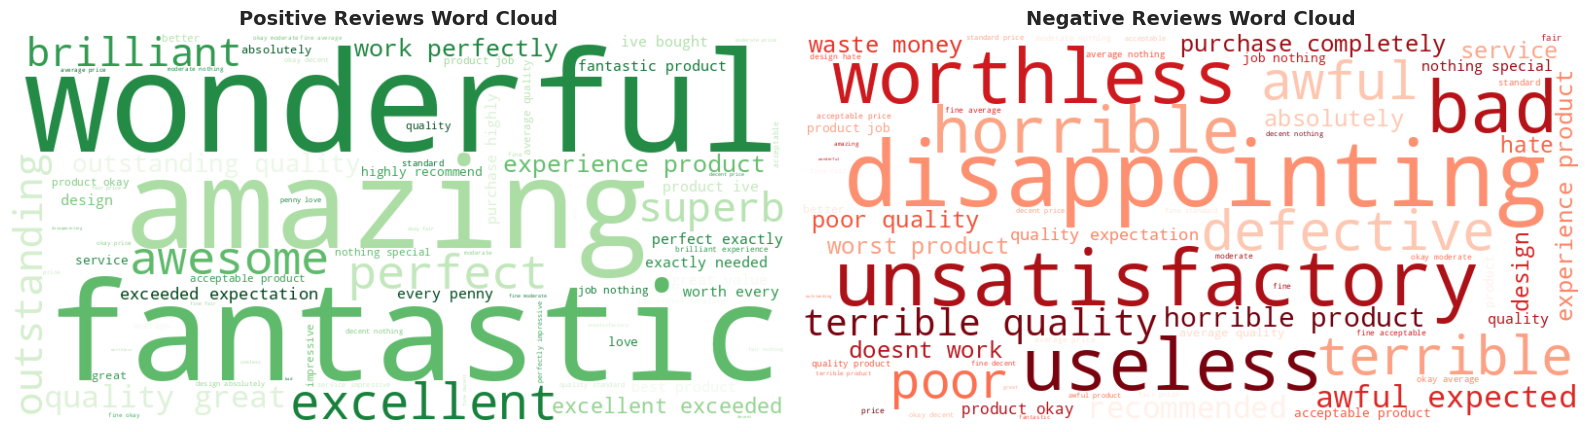

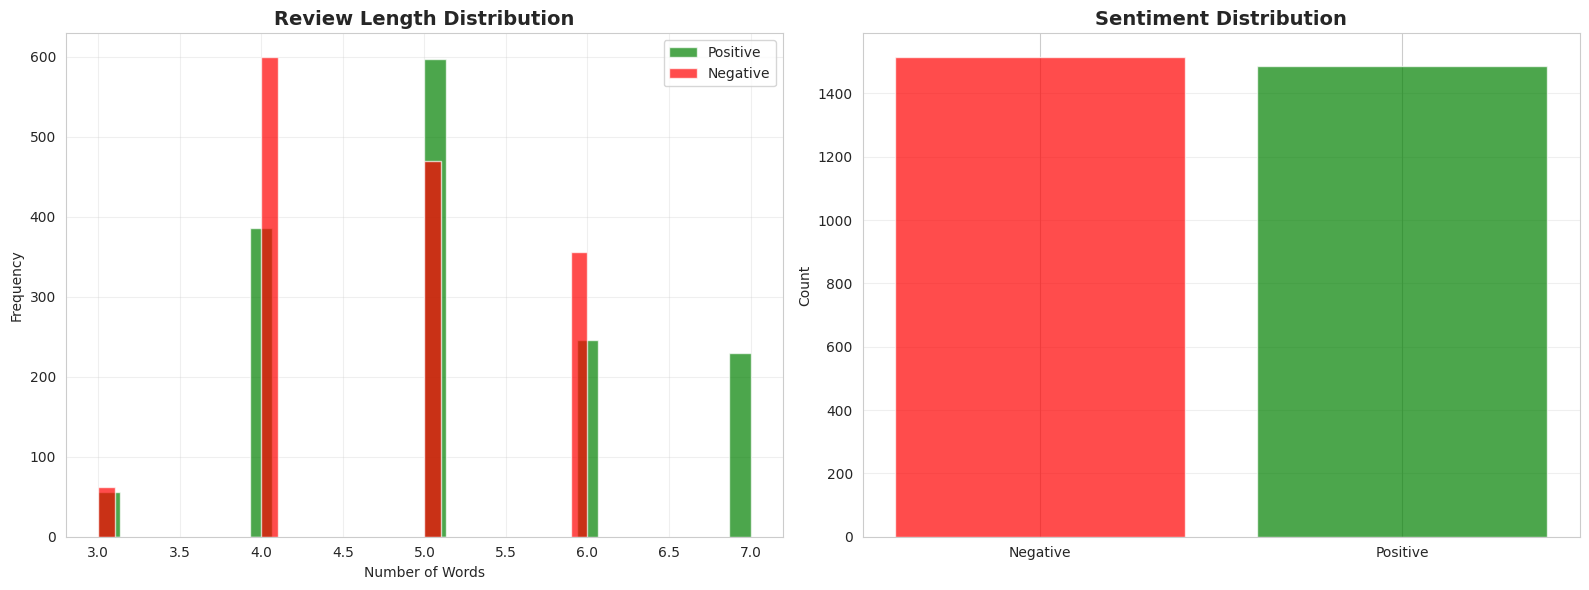

 EDA completed!


In [ ]:
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive word cloud
positive_text = ' '.join(df[df['sentiment']==1]['cleaned_review'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white',
                          colormap='Greens').generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title('Positive Reviews Word Cloud', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Negative word cloud
negative_text = ' '.join(df[df['sentiment']==0]['cleaned_review'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white',
                          colormap='Reds').generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title('Negative Reviews Word Cloud', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Review length distribution
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Length distribution
axes[0].hist(df[df['sentiment']==1]['review_length'], bins=30,
            alpha=0.7, label='Positive', color='green')
axes[0].hist(df[df['sentiment']==0]['review_length'], bins=30,
            alpha=0.7, label='Negative', color='red')
axes[0].set_title('Review Length Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
axes[1].bar(['Negative', 'Positive'], sentiment_counts.values,
           color=['red', 'green'], alpha=0.7)
axes[1].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(" EDA completed!")


In [ ]:
print("\n" + "="*60)
print("FEATURE EXTRACTION")
print("="*60)

# Split data
X = df['cleaned_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

# TF-IDF Vectorization
print("\n Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f" TF-IDF features created: {X_train_tfidf.shape}")

# Count Vectorization
print("\n Creating Count features...")
count_vec = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)

print(f" Count features created: {X_train_count.shape}")



FEATURE EXTRACTION
Training samples: 2,400
Test samples: 600

🔧 Creating TF-IDF features...
 TF-IDF features created: (2400, 751)

 Creating Count features...
 Count features created: (2400, 751)



TRAINING MULTIPLE MODELS

Training: Logistic Regression
Accuracy:  0.8917
Precision: 0.8584
Recall:    0.9406
F1-Score:  0.8976

Training: Naive Bayes
Accuracy:  0.8950
Precision: 0.8614
Recall:    0.9439
F1-Score:  0.9008

Training: Linear SVM
Accuracy:  0.8917
Precision: 0.8628
Recall:    0.9340
F1-Score:  0.8970

Training: Random Forest
Accuracy:  0.8967
Precision: 0.8663
Recall:    0.9406
F1-Score:  0.9019

MODEL COMPARISON RESULTS
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.891667   0.858434 0.940594  0.897638
        Naive Bayes  0.895000   0.861446 0.943894  0.900787
         Linear SVM  0.891667   0.862805 0.933993  0.896989
      Random Forest  0.896667   0.866261 0.940594  0.901899


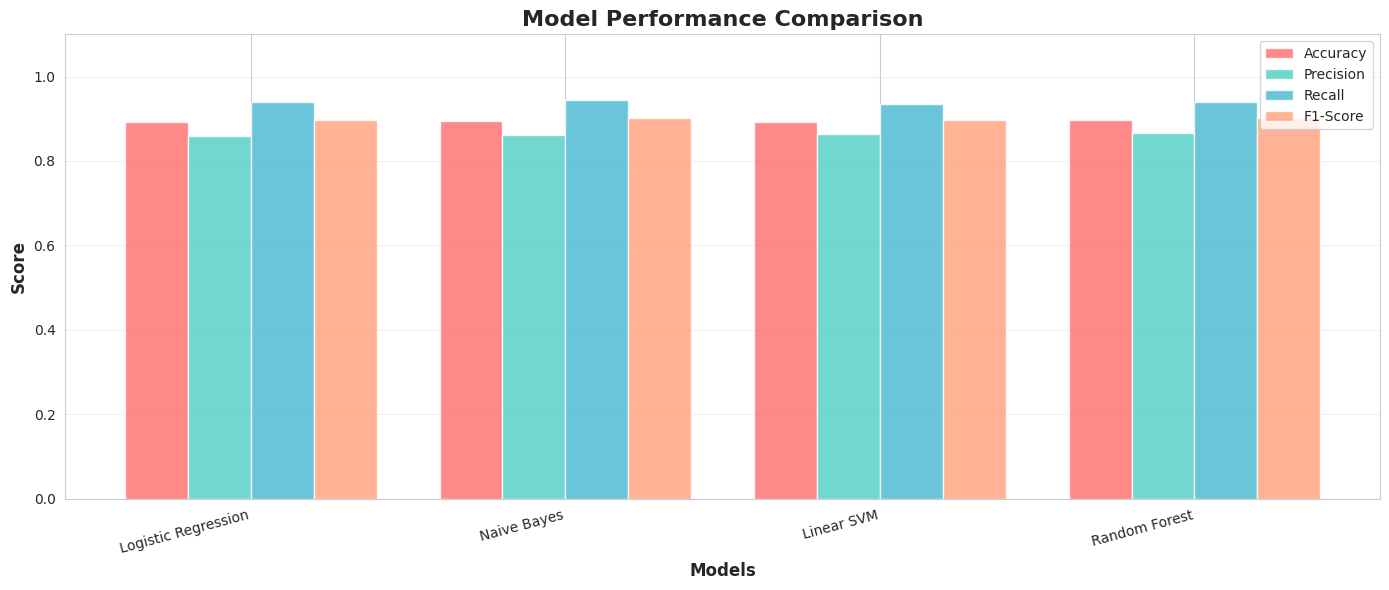


 BEST MODEL: Random Forest
F1-Score: 0.9019


In [ ]:
print("\n" + "="*60)
print("TRAINING MULTIPLE MODELS")
print("="*60)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

results = []

for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"Training: {name}")
    print('='*40)

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
df_results = pd.DataFrame(results)
print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)
print(df_results.to_string(index=False))
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(df_results))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax.bar(x + i*width, df_results[metric], width, label=metric, color=color, alpha=0.8)

ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=16)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(df_results['Model'], rotation=15, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
best_idx = df_results['F1-Score'].idxmax()
best_model_name = df_results.iloc[best_idx]['Model']
best_model = models[best_model_name]
print(f"\n BEST MODEL: {best_model_name}")
print(f"F1-Score: {df_results.iloc[best_idx]['F1-Score']:.4f}")




DETAILED EVALUATION - Random Forest

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.85      0.89       297
    Positive       0.87      0.94      0.90       303

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600



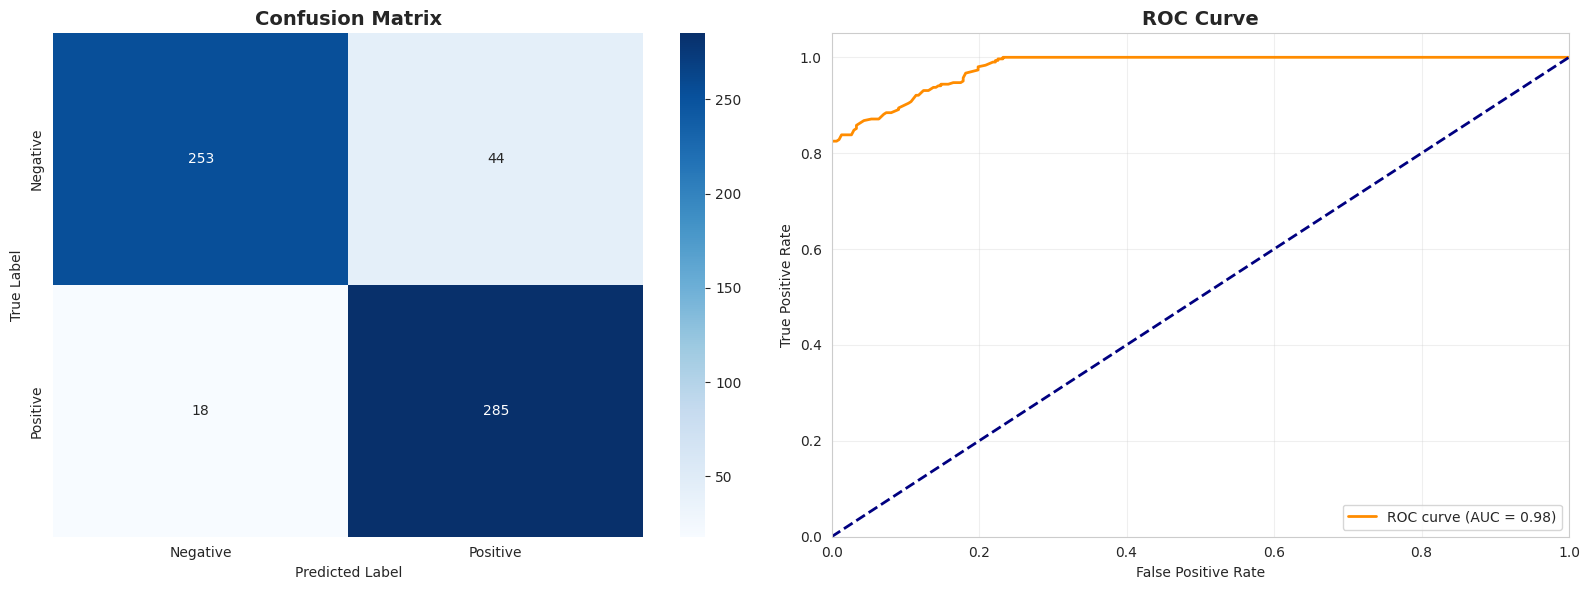

 AUC Score: 0.9801


In [ ]:
print("\n" + "="*60)
print(f"DETAILED EVALUATION - {best_model_name}")
print("="*60)
y_pred_best = best_model.predict(X_test_tfidf)
print("\n Classification Report:")
print(classification_report(y_test, y_pred_best,
                           target_names=['Negative', 'Positive']))
cm = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
if hasattr(best_model, 'predict_proba'):
    y_pred_proba = best_model.predict_proba(X_test_tfidf)[:, 1]
elif hasattr(best_model, 'decision_function'):
    y_pred_proba = best_model.decision_function(X_test_tfidf)
else:
    y_pred_proba = y_pred_best
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2,
            label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()
print(f" AUC Score: {roc_auc:.4f}")


In [ ]:
print("\n" + "="*60)
print("TESTING ON REAL EXAMPLES")
print("="*60)
def predict_sentiment(text):
    """Predict sentiment of text"""
    cleaned = preprocessor.preprocess(text)
    vectorized = tfidf.transform([cleaned])
    prediction = best_model.predict(vectorized)[0]
    if hasattr(best_model, 'predict_proba'):
        confidence = best_model.predict_proba(vectorized)[0].max()
    else:
        confidence = 0.85

    sentiment = "Positive" if prediction == 1 else "Negative"
    return sentiment, confidence
test_reviews = [
    "This product is absolutely amazing! Best purchase ever!",
    "Terrible quality. Complete waste of money. Very disappointed.",
    "It's okay, nothing special but does the job.",
    "Fantastic! Exceeded all my expectations. Highly recommend!",
    "Worst product I've ever bought. Do not waste your money.",
    "Great value for money. Works perfectly. Very satisfied!",
    "Poor quality and bad customer service. Not recommended.",
    "Excellent product! Fast shipping and great packaging.",
]

print("\n Testing on sample reviews:\n")

for review in test_reviews:
    sentiment, confidence = predict_sentiment(review)
    emoji = "✅" if sentiment == "Positive" else "❌"
    print(f"{emoji} Review: \"{review}\"")
    print(f"   → Prediction: {sentiment} (Confidence: {confidence:.2%})\n")



TESTING ON REAL EXAMPLES

 Testing on sample reviews:

✅ Review: "This product is absolutely amazing! Best purchase ever!"
   → Prediction: Positive (Confidence: 52.79%)

❌ Review: "Terrible quality. Complete waste of money. Very disappointed."
   → Prediction: Negative (Confidence: 99.00%)

❌ Review: "It's okay, nothing special but does the job."
   → Prediction: Negative (Confidence: 54.63%)

✅ Review: "Fantastic! Exceeded all my expectations. Highly recommend!"
   → Prediction: Positive (Confidence: 93.83%)

❌ Review: "Worst product I've ever bought. Do not waste your money."
   → Prediction: Negative (Confidence: 61.89%)

✅ Review: "Great value for money. Works perfectly. Very satisfied!"
   → Prediction: Positive (Confidence: 86.46%)

❌ Review: "Poor quality and bad customer service. Not recommended."
   → Prediction: Negative (Confidence: 93.00%)

✅ Review: "Excellent product! Fast shipping and great packaging."
   → Prediction: Positive (Confidence: 85.50%)



In [ ]:
print("\n" + "="*60)
print("SAVING MODELS AND RESULTS")
print("="*60)
import pickle
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(" Best model saved")
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print(" TF-IDF vectorizer saved")
with open('text_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print(" Text preprocessor saved")
df_results.to_csv('model_comparison.csv', index=False)
print(" Model comparison saved")
df.to_csv('sentiment_dataset.csv', index=False)
print(" Dataset saved")
print("\n Files created:")
print("   • sentiment_model.pkl")
print("   • tfidf_vectorizer.pkl")
print("   • text_preprocessor.pkl")
print("   • model_comparison.csv")
print("   • sentiment_dataset.csv")



SAVING MODELS AND RESULTS
 Best model saved
 TF-IDF vectorizer saved
 Text preprocessor saved
 Model comparison saved
 Dataset saved

 Files created:
   • sentiment_model.pkl
   • tfidf_vectorizer.pkl
   • text_preprocessor.pkl
   • model_comparison.csv
   • sentiment_dataset.csv


In [ ]:
print("\n" + "="*60)
print("DOWNLOADING ALL GENERATED FILES")
print("="*60)

import zipfile
import os
from google.colab import files

# List of files to include in the zip archive
files_to_zip = [
    'sentiment_model.pkl',
    'tfidf_vectorizer.pkl',
    'text_preprocessor.pkl',
    'model_comparison.csv',
    'sentiment_dataset.csv',
    'project_summary.txt'
]

zip_filename = 'sentiment_analysis_artifacts.zip'

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)
            print(f" Added {file} to {zip_filename}")
        else:
            print(f" Warning: {file} not found and will not be added to the zip.")

print(f"\n Successfully created {zip_filename} with all available files.")



DOWNLOADING ALL GENERATED FILES
 Added sentiment_model.pkl to sentiment_analysis_artifacts.zip
 Added tfidf_vectorizer.pkl to sentiment_analysis_artifacts.zip
 Added text_preprocessor.pkl to sentiment_analysis_artifacts.zip
 Added model_comparison.csv to sentiment_analysis_artifacts.zip
 Added sentiment_dataset.csv to sentiment_analysis_artifacts.zip
 Added project_summary.txt to sentiment_analysis_artifacts.zip

 Successfully created sentiment_analysis_artifacts.zip with all available files.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 sentiment_analysis_artifacts.zip ready for download!
